In [2]:
RESULTS_FOLDER = './intermediate_results/new_models_probs'

import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer, BertForMaskedLM, BertTokenizer, BartForConditionalGeneration, BartTokenizer

import os
from os.path import join, exists

os.chdir('/home/nwong/chompsky/serial_chain/telephone-analysis-public')

from new_models import prep_probs, model_score_funcs, model_score_utils, sub_analysis

import importlib
import load_runs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from collections import defaultdict


Checking whether right-side context is responsible for BERT "telephone" case

In [268]:
# Because BERT so position = logit position

# CLS and SEP have high values that can "wash out" the differences in the word attentions.
# The same is true for "MASK"

def plot_bertlike_attentions(raw_sentence, word, pos, mod, tok, pref, attn_threshold = None, omit_high_att = False):
    
    
    ##################################
    ### Get the attentions first #####
    ##################################
    
    sentence = model_score_utils.prepSentence(raw_sentence)
    position = sub_analysis.find_true_token_position(sentence, word, pos, tok)

    if position == -2: return None
    # The desired token was probably fragmented by the tokenizer, this shouldn't happen if you're running the book case.

    # + 1 because CLS is not accounted for in the original index. This is for correctness of the prefixes.
    logit_pos = position + 1
    token_prefix, orig_tokens = pref(sentence, tok, [logit_pos])

    # Run the actual prediction

    this_input = torch.Tensor(token_prefix)
    
    with torch.no_grad():
        raw_outputs = mod(this_input.long() if len(this_input.shape) == 1 else this_input.long(), output_attentions=True)
        index_attentions = 'attentions' if isinstance(tok, transformers.models.bert.tokenization_bert.BertTokenizer) else 'encoder_attentions'
        raw_attn = raw_outputs[index_attentions] 
        # encoder_attentions is also available for BART
        # but BART encoder = BERTlike, BART decoder = GPT2 like

        
    ##################################
    ### Plotting the attentions ######
    ##################################

    # Note: Display the layers jointly because there may be differences across layers
    
    raw_attn = torch.cat(raw_attn, dim = 0)
    # raw_attn : (layers, attention heads, query positions, key positions)
    
    # 6/2: Fixing max return types:
    # https://stackoverflow.com/questions/60847083/attributeerror-torch-return-types-max-object-has-no-attribute-dim-maxpool
    
    this_input_tokens = tok.convert_ids_to_tokens(token_prefix[0])
    this_ground_truth_word = this_input_tokens[logit_pos]
    
    token_words = tok.convert_ids_to_tokens(token_prefix[0])
    ground_truth_word = tok.convert_ids_to_tokens([orig_tokens[logit_pos]][0])
    
    if not omit_high_att:    
        # So max over all of the layers and the attention modules
        display_attn = torch.max(raw_attn[:, :, pos, :], axis = 1).values
        display_words = token_words
    else:    
        # Omit the CLS, SEP, and punctuation
        display_attn = torch.max(raw_attn[:, :, pos, 1:-2], axis = 1).values
        display_words = token_words[1:-2]

    num_x_ticks = len(display_words)
    
    if attn_threshold is not None:
        display_attn = torch.clip(display_attn, 0, attn_threshold)

    # For text annotations and color bar
    # 6/2 : https://www.pythonprogramming.in/heatmap-with-intermediate-color-text-annotations.html

    fig, ax = plt.subplots(figsize=(15, 15))
    
    plt.title(f'Max over attention modules, attention for word: {ground_truth_word}')

    im = ax.imshow(display_attn.numpy(), cmap = "YlGnBu")
    fig.colorbar(im)

    textcolors = ["k", "w"] 

    #6/2 hide ticks: https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
    #6/2 rotation: https://www.delftstack.com/howto/matplotlib/how-to-rotate-x-axis-tick-label-text-in-matplotlib/
    #6/2 xtick text: https://www.mathworks.com/help/matlab/creating_plots/change-tick-marks-and-tick-labels-of-graph-1.html
    
    plt.ylabel('Layer number')
    #plt.yticks(color = 'w')

    plt.xticks(range(num_x_ticks), display_words, rotation = 45)
    threshold = 55/255
    
    for i in range(raw_attn.shape[0]):
        for j in range(num_x_ticks): 
            this_val = round(display_attn[i][j].item(), 3)
            ax.text(j, i, this_val, ha="center", va="center", color=textcolors[this_val > threshold])

    # End taken code
    
    plt.show()


In [262]:
# To change the case that this is run on, change the below line:

def calc_and_plot_bertlike_attention(case_info, this_mod, this_tok, this_pref,
                                 attn_threshold = None, omit_high_att = False):
    
    this_raw_sentence, this_word, this_pos = case_info
    
    plot_bertlike_attentions(this_raw_sentence, this_word, this_pos, this_mod, this_tok, this_pref,
                         attn_threshold = attn_threshold, omit_high_att = omit_high_att)


In [263]:
type(bert_args[1])

transformers.models.bert.tokenization_bert.BertTokenizer

In [258]:
bert_args = model_score_funcs.get_bert_modules()
bart_args = model_score_funcs.get_bart_modules()

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


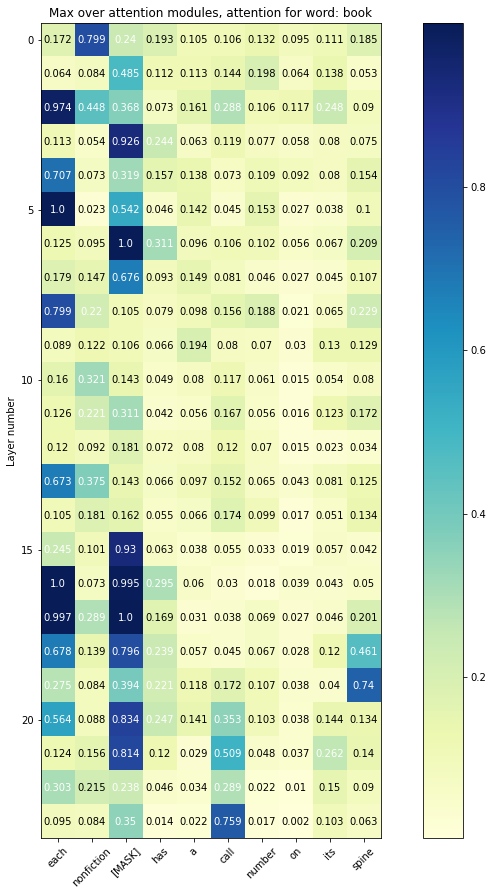

NameError: name 'bart_args' is not defined

In [256]:
# attn_threshold: Manually chosen to be a little bit above the max attention after the CLS SEP and MASK, 0.079
# This only applies to mean though

book_phone_case = ("each nonfiction book has a call number on its spine", 'book', 2)
#book_phone_case = ("this winter I went ice skating", 'skating', 5)
calc_and_plot_bertlike_attention(book_phone_case, *bert_args, None, True)

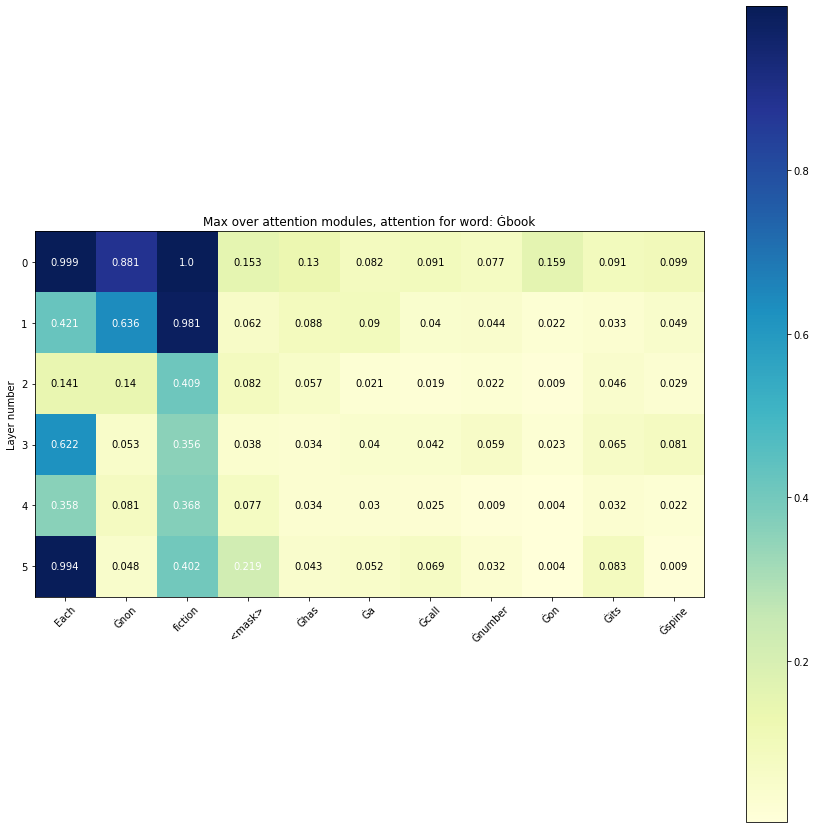

In [269]:
# Check whether the BART attention index is set to encoder or decoder before using.

calc_and_plot_bertlike_attention(book_phone_case, *bart_args, None, True)